In [1]:
import numpy as np
import h5py
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt


1. define a perfect transmission AR coating

In [2]:
def ideal_AR(angle0,angle1,N =201, outputfname = 'Ideal_AR.h5'):
    """ 
    Fresnel Coefficients of Ideal AR COATING,
    t and r are in amplitude, not intensity.
    t and r are complex values
    t and r are different with the real Fresnel coefficients for E and H fields.
    becuase the Fresnel coefficients for E and H fields are dependent on n1 and n2. 
    """
    theta = np.linspace(angle0, angle1, N)/180*np.pi
    rp = np.zeros_like(theta)*np.exp(1j*np.pi)
    rs = np.zeros_like(theta)*np.exp(1j*np.pi)
    tp = np.ones_like(theta)*np.exp(1j*0)
    ts = np.ones_like(theta)*np.exp(1j*0)


    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    #ax.plot(theta * 180 / np.pi, 20*np.log10(np.abs(rp)), label='rp', color='blue')
    #ax.plot(theta * 180 / np.pi, 20*np.log10(np.abs(rs)), label='rs', color='orange')
    ax.plot(theta * 180 / np.pi, 20*np.log10(np.abs(tp)), label='tp', color='green')
    ax.plot(theta * 180 / np.pi, 20*np.log10(np.abs(ts)), label='ts', color='red')
    ax.set_xlabel('Angle of incidence (degrees)')
    ax.set_ylabel('Fresnel Coefficients')
    ax.set_title('Fresnel Coefficients for Ideal AR Coating')
    ax.legend()
    ax.grid()
    plt.show()


    with h5py.File(outputfname, 'w') as f:
        g = f.create_group('ideal_AR')
        g.create_dataset('theta', data=theta)
        g.create_dataset('rp', data=rp)
        g.create_dataset('rs', data=rs)
        g.create_dataset('tp', data=tp)
        g.create_dataset('ts', data=ts)
    return theta, rp, rs, tp, ts


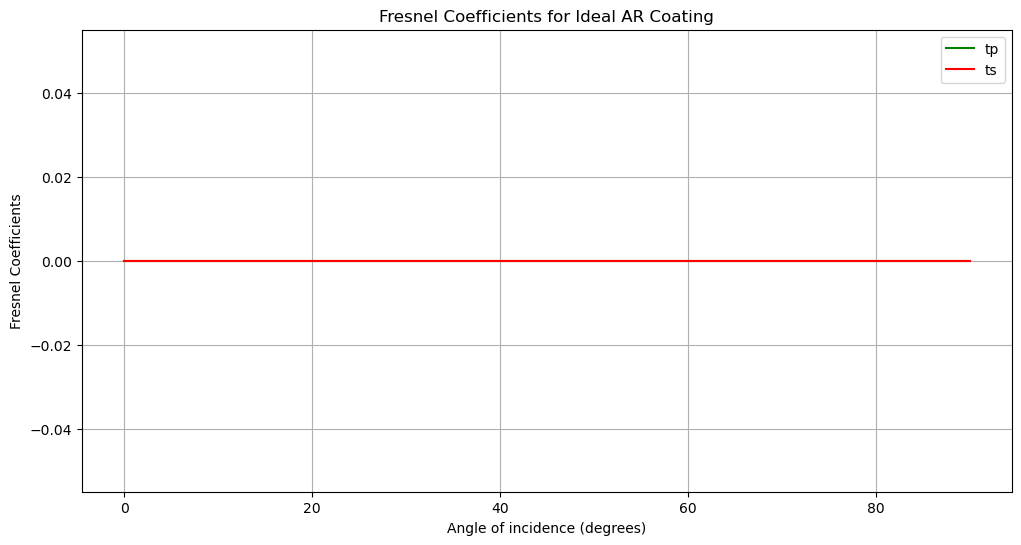

In [3]:
data  = ideal_AR(0, 90, N=501, outputfname='Ideal_AR.h5')


In [ ]:
### Fresnel coefficients for surface with AR coating
def Creat_Fresnel_coeffi_AR(theta_i,t_p,r_p,t_s,r_s,n1,n2):
    ### To be noted that t and r are the coefficients from air to silicon.
    tp_AR = CubicSpline(theta_i,t_p)
    rp_AR = CubicSpline(theta_i,r_p)
    ts_AR = CubicSpline(theta_i,t_s)
    rs_AR = CubicSpline(theta_i,r_s)
    def Fresnel_coeffi_AR1(theta):
        t_p = tp_AR(theta)
        t_s = ts_AR(theta)
        r_p = rp_AR(theta)
        r_s = rs_AR(theta)
        return t_p,t_s,r_p,r_s
    def Fresnel_coeffi_AR2(theta):
        theta_t = np.arcsin(n2*np.sin(theta)/n1)
        factor = (n2/n1)* (np.cos(theta)/np.cos(theta_t))
        t_p = tp_AR(theta_t) * factor
        t_s = ts_AR(theta_t) * factor
        r_p = rp_AR(theta_t)
        r_s = rs_AR(theta_t)
        return t_p,t_s,r_p,r_s
    return Fresnel_coeffi_AR1,Fresnel_coeffi_AR2

def read_Fresnel_coeffi_AR(filename, groupname, n1, n2):
    with h5py.File(filename, 'r') as f:
        if groupname in f:
            group = f[groupname]
            theta_i = group['theta'][:]
            theta_t = np.arcsin(n1/n2 * np.sin(theta_i))
            tp = group['tp'][:]
            rp = group['rp'][:]
            ts = group['ts'][:]
            rs = group['rs'][:]
            factor = np.sqrt(n1 * np.cos(theta_i) / n2 /np.cos(theta_t))
            tp = tp * factor
            ts = ts * factor
            Fresnel_coeffi_AR1,Fresnel_coeffi_AR2 = Creat_Fresnel_coeffi_AR(theta_i,tp,rp,ts,rs,n1,n2)
            return Fresnel_coeffi_AR1, Fresnel_coeffi_AR2
        else:
            print(f"Group '{groupname}' not found in the file.")
            return None,None


In [ ]:
AR1,AR2 = read_Fresnel_coeffi_AR('Ideal_AR.h5', 'ideal_AR', 1.0, 3.36)


In [ ]:
Angle = np.linspace(0,80,201)/180*np.pi
t_p, t_s, r_p, r_s = AR1(Angle)
plt.figure(figsize=(12, 6))
plt.plot(Angle * 180 / np.pi, np.abs(t_p), label='tp', color='green')
plt.plot(Angle * 180 / np.pi, np.abs(t_s), label='ts', color='red')


In [ ]:
Angle = np.linspace(0,15,201)/180*np.pi
t_p, t_s, r_p, r_s = AR2(Angle)
plt.figure(figsize=(12, 6))
plt.plot(Angle * 180 / np.pi, np.abs(t_p), label='tp', color='green')
plt.plot(Angle * 180 / np.pi, np.abs(t_s), label='ts', color='red')


In [ ]:
n1 = 1.0
n2 = 3.36
theta_t = np.arcsin(n2/n1 * np.sin(Angle))
